In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-football/real.csv
/kaggle/input/fake-news-football/fake.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
from wordcloud import WordCloud
from collections import Counter
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_20/1816089990.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
df_real=pd.read_csv('/kaggle/input/fake-news-football/real.csv')
df_fake=pd.read_csv('/kaggle/input/fake-news-football/fake.csv')

In [6]:
df_real['label']=0
df_fake['label']=1
df=pd.concat([df_real,df_fake],ignore_index=True)

In [7]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41851 entries, 0 to 41867
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   41851 non-null  object
 1   label   41851 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 980.9+ KB


In [8]:
df['label'].value_counts()

0    21863
1    19988
Name: label, dtype: int64

### Tweets Deep Cleaning

In [9]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text, language='en') #remove emoji
    
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(@|https?\:\/\/)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

#remove stopwords
def remove_stopwords(text):
    new_list = []
    words = text.split()
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

#lemmatization 
def perform_lemmatization(text):
    wnl = WordNetLemmatizer()
    new_list = []
    words = text.split()
    for word in words:
        new_list.append(wnl.lemmatize(word))

    return " ".join(new_list)


In [10]:
df['tweet'] = df['tweet'].apply(lambda t : remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [11]:
#df['tweet'] = df['tweet'].apply(lambda t : perform_lemmatization(remove_stopwords(t)))

# **EDA & Visualization**

### Kdeplot by Total Words

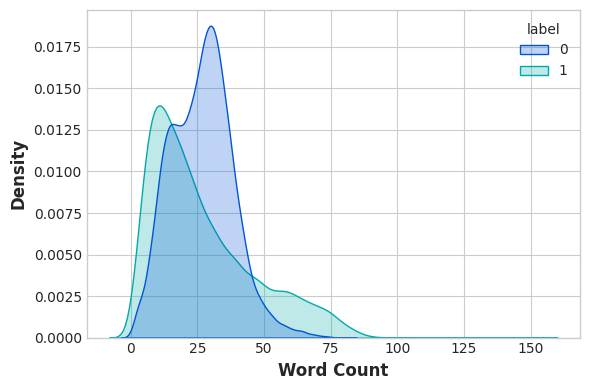

In [12]:
plt.figure(figsize = (6, 4))
sns.kdeplot(x = df['tweet'].apply(lambda x:len(x.split())), hue= df['label'], palette= 'winter', fill = True)
plt.xlabel('Word Count')
plt.show()

### WordCloud

In [13]:
def wordcloud_text(text):
    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [14]:
real_text = " ".join(df[df['label'] == 0]['tweet'])
fake_text = " ".join(df[df['label'] == 0]['tweet'])

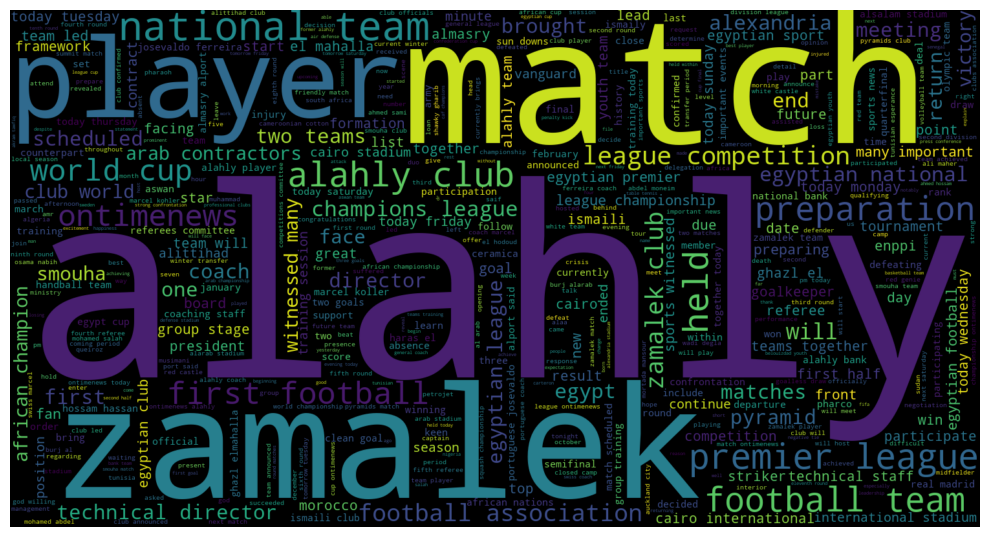

In [15]:
wordcloud_text(real_text)

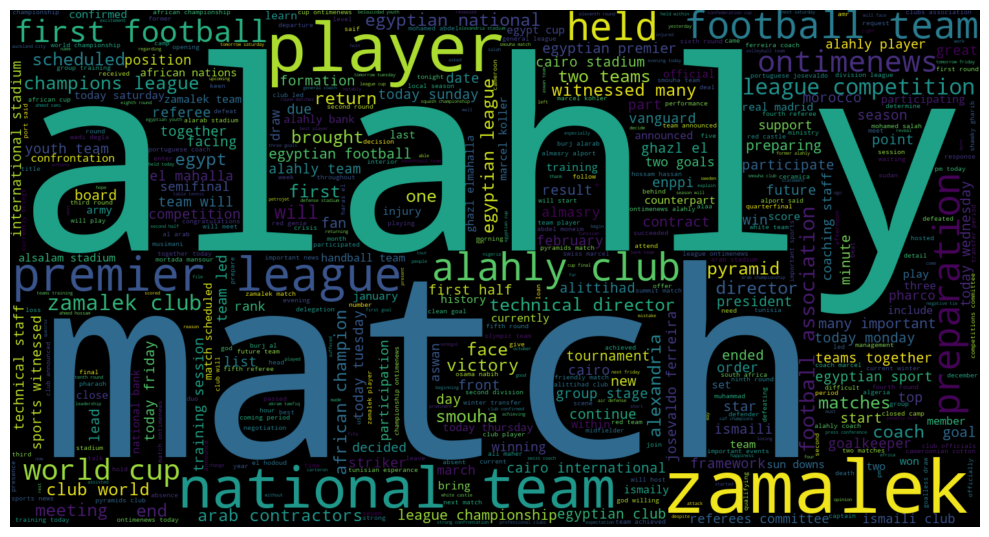

In [16]:
wordcloud_text(fake_text)

### Word Frequency

In [17]:
def plot_words_freq(words):
    df1 = pd.DataFrame(Counter(words).most_common(25), columns= ['Word', 'Frequency'])

    sns.set_context('notebook', font_scale= 1.3)
    plt.figure(figsize=(10,8))
    sns.barplot(y = df1['Word'], x= df1['Frequency'], palette= 'summer')
    plt.title("Most Commonly Used Words in Real News")
    plt.xlabel("Frequnecy")
    plt.ylabel("Words") 
    return plt.show()

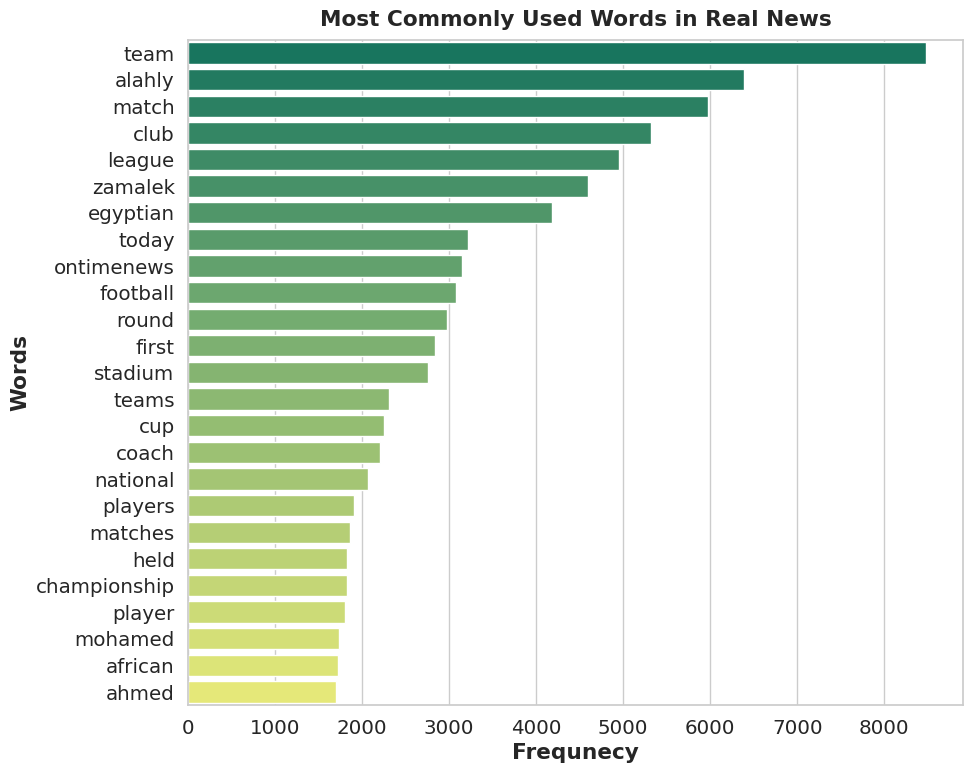

In [18]:
plot_words_freq(remove_stopwords(real_text).split())

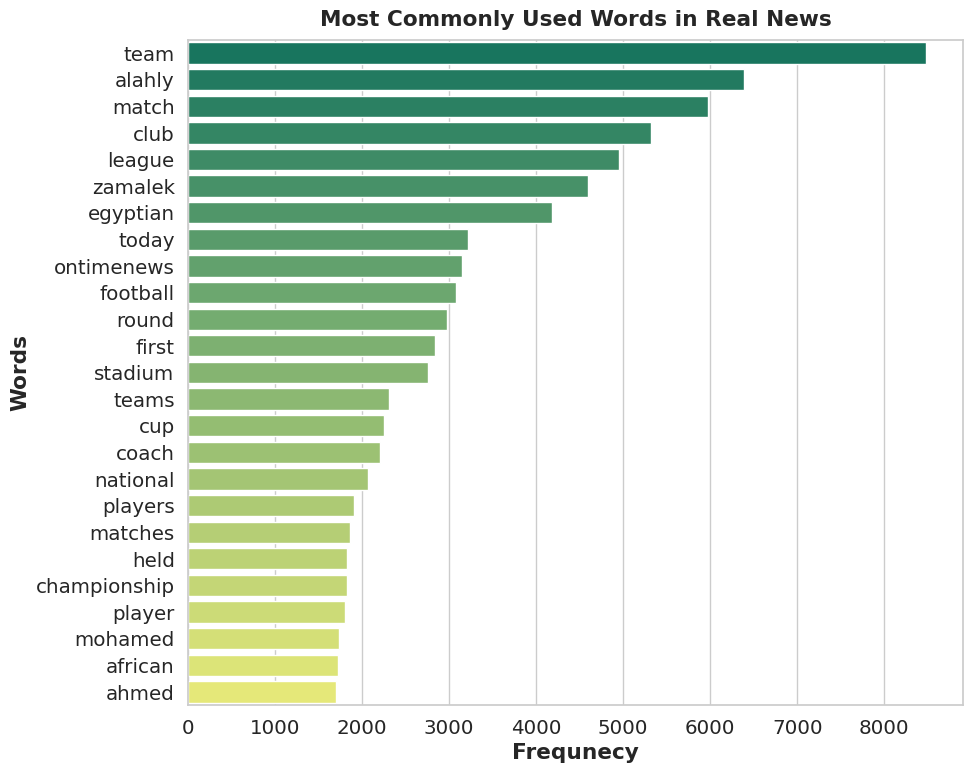

In [19]:
plot_words_freq(remove_stopwords(fake_text).split())

## Bigram

In [20]:
df['tweet_len'] = df['tweet'].apply(lambda x: len(x.split()))

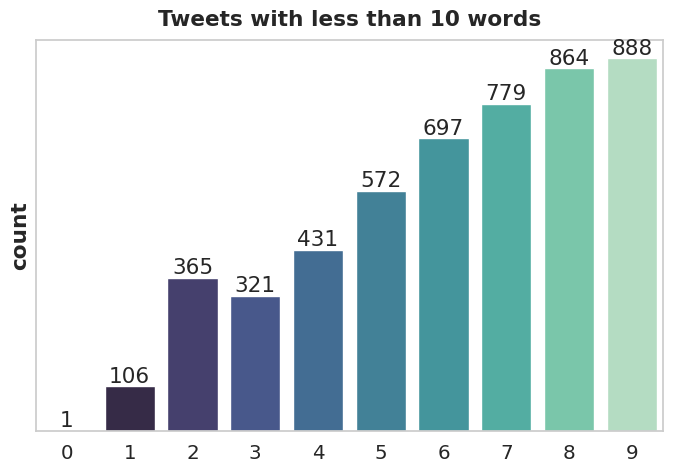

In [21]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='tweet_len', data=df[df['tweet_len']<10], palette='mako')
plt.title('Tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We will drop these empty tweets and also those with less than 5 words.

In [22]:
df = df[df['tweet_len'] > 4]

In [23]:
df[df['tweet_len']>100]

,tweet,label,tweet_len
24774,yesterday i decided to go and play football wi...,1,103
34592,crown prince alahly destroys 1 ha ha ha ha ha ...,1,152
35017,a boy met me on the street you hadnt seen him ...,1,102


In [24]:
y = df["label"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["tweet"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

# **Vectorization -- Word2Vec**
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [25]:
import gensim

In [26]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [27]:
#vocab size
len(w2v_model.wv.index_to_key)

#We have now represented each of 26025 words by a 100dim vector.

26025

**Exploring Vectors**
Lets checkout these vectors

In [28]:
#see a sample vector for random word, lets say Corona 
w2v_model.wv["match"]

array([-1.3819938 ,  0.5970224 ,  0.8928932 , -0.4550486 , -2.1967976 ,
       -0.95992494,  0.40020922,  1.015745  , -1.918985  , -1.357876  ,
       -0.91833395, -0.77268535, -1.1424397 ,  0.3044805 ,  0.4918186 ,
       -1.1024561 , -1.119763  , -0.6479816 , -1.4689704 , -1.117506  ,
       -2.29228   , -1.3334213 ,  0.37825343,  0.23204993, -1.8112739 ,
       -0.65823287, -1.1638964 , -0.61208206,  1.3632336 ,  1.052352  ,
        0.8307526 , -0.5051563 ,  0.13829103,  1.3977845 , -0.6291161 ,
        1.9430612 ,  0.89090365, -0.63991785,  0.6810904 , -1.0547886 ,
        1.7130839 , -0.615747  , -1.2125771 , -1.6588978 ,  0.27821526,
        0.3507734 , -0.7581241 ,  0.7146907 ,  0.4294996 , -0.2236102 ,
       -0.41302812, -1.2972007 , -0.08678065,  0.7334493 , -0.27541542,
        1.5732303 ,  1.0455973 , -2.0690415 , -1.5025442 , -1.8802396 ,
        0.6461052 ,  0.09124099,  0.7393742 , -1.6111745 ,  1.0997447 ,
        1.5194217 ,  1.8165796 , -1.7107539 , -1.4018813 , -0.66

In [29]:
w2v_model.wv.most_similar("match")

[('confrontation', 0.8084851503372192),
 ('face', 0.7318564057350159),
 ('tied', 0.7229040861129761),
 ('asco', 0.7098326683044434),
 ('meet', 0.7027231454849243),
 ('aljaish', 0.6992954611778259),
 ('51st', 0.69852614402771),
 ('talaa', 0.6950443983078003),
 ('almokawloon', 0.6865496635437012),
 ('faces', 0.6723109483718872)]

In [30]:
w2v_model.wv.most_similar("today")

[('tomorrow', 0.8893579840660095),
 ('1252023', 0.8150784969329834),
 ('evening', 0.7707551717758179),
 ('afternoon', 0.7683511972427368),
 ('382023', 0.7569506168365479),
 ('930', 0.7394912242889404),
 ('morning', 0.7379434108734131),
 ('12282022', 0.7359587550163269),
 ('yesterday', 0.7305101752281189),
 ('formula', 0.7300452589988708)]

**Looking at the similar words, vectors are well formed for these words**

These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors.

Keras has implementation called "Embedding Layer" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.

We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [31]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [32]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break      

alahly -> 1
team -> 2
league -> 3
zamalek -> 4
haha -> 5
match -> 6
club -> 7
egyptian -> 8
football -> 9
today -> 10


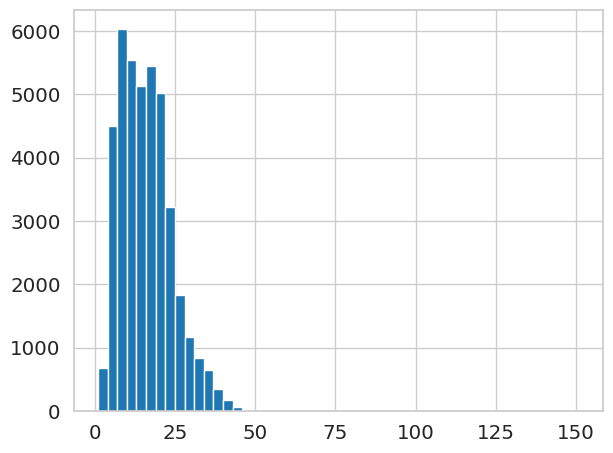

In [33]:

# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 150 words.
# Lets keep each news small and truncate all news to 50 while tokenizing
plt.hist([len(x) for x in X], bins=50)
plt.show()

# Its heavily skewed. There are news with 150 words? Lets truncate these outliers :) 

In [34]:
#Lets keep all news to 50, add padding to news with less than 700 words and truncating long ones
maxlen = 50 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [35]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [36]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [37]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [38]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
#model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
#model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#del embedding_vectors

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2602600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,721,929
Trainable params: 119,329
Non-tr

In [40]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [41]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
667/667 [==============================] - 54s 76ms/step - loss: 0.2073 - acc: 0.9201 - val_loss: 0.1536 - val_acc: 0.9425
Epoch 2/6
667/667 [==============================] - 51s 76ms/step - loss: 0.1556 - acc: 0.9407 - val_loss: 0.1386 - val_acc: 0.9431
Epoch 3/6
667/667 [==============================] - 51s 76ms/step - loss: 0.1401 - acc: 0.9465 - val_loss: 0.1398 - val_acc: 0.9466
Epoch 4/6
667/667 [==============================] - 51s 76ms/step - loss: 0.1260 - acc: 0.9510 - val_loss: 0.1332 - val_acc: 0.9478
Epoch 5/6
667/667 [==============================] - 51s 76ms/step - loss: 0.1114 - acc: 0.9577 - val_loss: 0.1409 - val_acc: 0.9440
Epoch 6/6
667/667 [==============================] - 51s 76ms/step - loss: 0.1009 - acc: 0.9598 - val_loss: 0.1232 - val_acc: 0.9490


In [42]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

318/318 [==============================] - 10s 28ms/step


In [43]:
accuracy_score(y_test, y_pred)*100

94.48656099241902

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5415
           1       0.92      0.96      0.94      4742

    accuracy                           0.94     10157
   macro avg       0.94      0.95      0.94     10157
weighted avg       0.95      0.94      0.94     10157



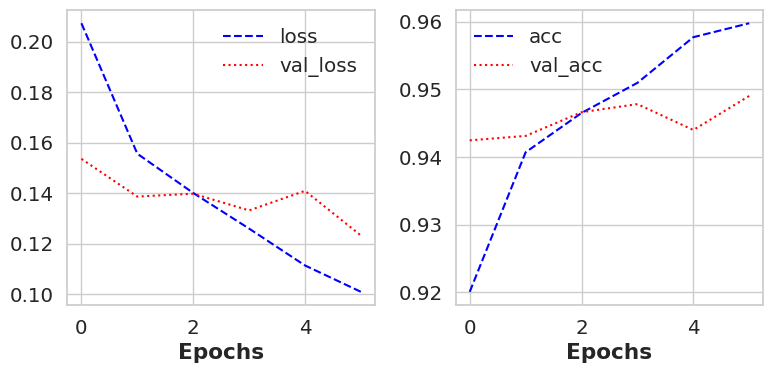

In [45]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], 'b--', label = 'acc')
plt.plot(history.history['val_acc'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Using Pre-Trained Word2Vec Vectors


Now, instead of creating word vectors, let us use pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.


add Dataset from https://www.kaggle.com/sandreds/googlenewsvectorsnegative300

In [46]:
from gensim.models.keyedvectors import KeyedVectors

In [47]:
word_vectors = KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)
EMBEDDING_DIM=300

In [48]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del word_vectors 

In [49]:
history=model.fit(X_train, y_train, validation_split=0.2, epochs=5)

Epoch 1/5
762/762 [==============================] - 55s 72ms/step - loss: 0.0925 - acc: 0.9641 - val_loss: 0.1337 - val_acc: 0.9488
Epoch 2/5
762/762 [==============================] - 55s 73ms/step - loss: 0.0819 - acc: 0.9689 - val_loss: 0.1380 - val_acc: 0.9449
Epoch 3/5
762/762 [==============================] - 56s 73ms/step - loss: 0.0703 - acc: 0.9725 - val_loss: 0.1401 - val_acc: 0.9495
Epoch 4/5
762/762 [==============================] - 55s 73ms/step - loss: 0.0611 - acc: 0.9757 - val_loss: 0.1499 - val_acc: 0.9481
Epoch 5/5
762/762 [==============================] - 56s 73ms/step - loss: 0.0524 - acc: 0.9792 - val_loss: 0.1559 - val_acc: 0.9493


In [50]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

318/318 [==============================] - 9s 29ms/step


In [51]:
accuracy_score(y_test, y_pred)

0.9489022349118834

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5415
           1       0.94      0.95      0.95      4742

    accuracy                           0.95     10157
   macro avg       0.95      0.95      0.95     10157
weighted avg       0.95      0.95      0.95     10157

